In [33]:
import sys
sys.path.append("../src")
sys.path.append("../data/embeddings")
sys.path.append("../data/biasbios")
sys.path.append("../data/embeddings/biasbios")
import classifier
import svm_classifier
import debias
import gensim
import codecs
import json
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
import numpy as np
import random
import sklearn
from sklearn import model_selection
from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import DictVectorizer
from pytorch_transformers import BertTokenizer, BertModel, BertForMaskedLM

import scipy
from scipy import linalg
from scipy import sparse
from scipy.stats.stats import pearsonr
import tqdm
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier, SGDRegressor, Perceptron, LogisticRegression

%matplotlib inline
matplotlib.rcParams['agg.path.chunksize'] = 10000

import warnings
warnings.filterwarnings("ignore")

import pickle
from collections import defaultdict, Counter
from typing import List, Dict

import torch
from torch import utils

import pytorch_lightning as pl
from pytorch_lightning import Trainer
import copy
import pandas as pd
from gensim.models import FastText
import time
from gensim.scripts.glove2word2vec import glove2word2vec

STOPWORDS = set(["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"])

In [25]:


def load_dataset(path):
    
    with open(path, "rb") as f:
        
        data = pickle.load(f)
    return data

def load_dictionary(path):
    
    with open(path, "r", encoding = "utf-8") as f:
        
        lines = f.readlines()
        
    k2v, v2k = {}, {}
    for line in lines:
        
        k,v = line.strip().split("\t")
        v = int(v)
        k2v[k] = v
        v2k[v] = k
    
    return k2v, v2k
    
def count_profs_and_gender(data: List[dict]):
    
    counter = defaultdict(Counter)
    for entry in data:
        gender, prof = entry["g"], entry["p"]
        counter[prof][gender] += 1
        
    return counter


In [61]:
train = load_dataset("../data/biasbios/train1.pickle")
dev = load_dataset("../data/biasbios/dev1.pickle")
test = load_dataset("../data/biasbios/test1.pickle")

#w2i, i2w = load_dictionary("../data/biasbios/word2index.txt")
p2i, i2p = load_dictionary("../data/biasbios/profession2index.txt")
g2i, i2g = load_dictionary("../data/biasbios/gender2index.txt")
counter = count_profs_and_gender(train+dev+test)

In [62]:
f,m = 0., 0.
prof2fem = dict()

for k, values in counter.items():
    f += values['f']
    m += values['m']
    prof2fem[k] = values['f']/(values['f'] + values['m'])

print(f / (f + m))
print(prof2fem)

0.46286566875856267
{'photographer': 0.35721920736720936, 'poet': 0.49080017115960634, 'journalist': 0.49488721804511276, 'professor': 0.45118956904580476, 'software_engineer': 0.1576889661164205, 'psychologist': 0.6223011751844766, 'architect': 0.23712053792148718, 'surgeon': 0.14857228961048746, 'attorney': 0.38316925813475633, 'painter': 0.4579886246122027, 'nurse': 0.9085446207369142, 'physician': 0.507688318423441, 'interior_designer': 0.8086124401913876, 'teacher': 0.603111879476414, 'accountant': 0.36818825194621374, 'chiropractor': 0.26558891454965355, 'dentist': 0.35589474411216243, 'model': 0.8283124500133298, 'filmmaker': 0.3295762590954487, 'yoga_teacher': 0.8454600120264583, 'composer': 0.16392857142857142, 'pastor': 0.24052132701421802, 'personal_trainer': 0.45670391061452514, 'dj': 0.1420875420875421, 'rapper': 0.09665955934612651, 'dietitian': 0.9273504273504274, 'comedian': 0.21150410861021793, 'paralegal': 0.8483305036785512}


In [63]:
print(p2i)

{'accountant': 0, 'architect': 1, 'attorney': 2, 'chiropractor': 3, 'comedian': 4, 'composer': 5, 'dentist': 6, 'dietitian': 7, 'dj': 8, 'filmmaker': 9, 'interior_designer': 10, 'journalist': 11, 'model': 12, 'nurse': 13, 'painter': 14, 'paralegal': 15, 'pastor': 16, 'personal_trainer': 17, 'photographer': 18, 'physician': 19, 'poet': 20, 'professor': 21, 'psychologist': 22, 'rapper': 23, 'software_engineer': 24, 'surgeon': 25, 'teacher': 26, 'yoga_teacher': 27}


### get input representatons 

In [65]:

def load_word_vectors(fname = "../data/embeddings/vecs.filtered.with_gendered.glove.txt"):
    
    model = KeyedVectors.load_word2vec_format(fname, binary=False)
    vecs = model.vectors
    words = list(model.vocab.keys())
    return model, vecs, words


def get_embeddings_based_dataset(data: List[dict], word2vec_model, p2i, filter_stopwords = False):
    
    X, Y = [], []
    unk, total = 0., 0.
    unknown = []
    
    for entry in tqdm.tqdm(data, total = len(data)):
        
        y = p2i[entry["p"]]
        words = entry["hard_text"].replace(",","").replace(".", "").split(" ")
        if filter_stopwords:
            words = [w for w in words if w.lower() not in STOPWORDS]
            
        bagofwords = np.sum([word2vec_model[w] if w in word2vec_model else word2vec_model["unk"] for w in words], axis = 0)
        #print(bagofwords.shape)
        X.append(bagofwords)
        Y.append(y)
        total += len(words)
        
        unknown_entry = [w for w in words if w not in word2vec_model]
        unknown.extend(unknown_entry)
        unk += len(unknown_entry)
    
    X = np.array(X)
    Y = np.array(Y)
    print("% unknown: {}".format(unk/total))
    return X,Y,unknown

def get_BOW_based_dataset(data: List[dict], w2i):
    
    vectorizer = DictVectorizer(sparse = True)
    X, Y = [], []
    unk, total = 0., 0.
    data_dicts = []
    unknown = []
    
    for entry in tqdm.tqdm(data, total = len(data)):
        text, start, y = entry["text"], entry["start"], entry["p"]
        #text = text.lower()
        words = text[start + 1:].split(" ")
        entry_dict = {w:w2i[w] if w in w2i else w2i["<UNK>"] for w in words}
        data_dicts.append(entry_dict)
        Y.append(y)
        
        total += len(words)
        unknown_entry = [w for w in words if w not in w2i]
        unk += len([w for w in words if w not in w2i])
    
    print("% unknown: {}".format(unk/total))
    X = vectorizer.fit_transform(data_dicts)
    return X,Y
    
def get_bert_based_dataset(data: List[dict], p2i):
    
    tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
    model = BertModel.from_pretrained('bert-base-cased').cuda()
    model.eval()
    
    X, Y = [], []
    cls_lst = ['[CLS]']
    sep_lst = ['[SEP]']
    
    for entry in tqdm.tqdm(data, total = len(data)):
        text, y = entry["hard_text"], p2i[entry["p"]]
        #text = text.lower()            
        tokenized_text = cls_lst + tokenizer.tokenize(text)[:500] + sep_lst    
        indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
        tokens_tensor = torch.tensor([indexed_tokens]).cuda()
        with torch.no_grad():
              outputs = model(tokens_tensor)[0]
              out_np = outputs.detach().cpu().numpy()
              out_np = out_np.squeeze(0)
              BOW = out_np[-1][:] #np.sum(out_np, axis = 0)
              X.append(BOW)
              Y.append(y)
    
    X = np.array(X)
    Y = np.array(Y)
    
    return X,Y

In [30]:
#word2vec, vecs, words = load_word_vectors("../data/embeddings/wiki-news-300d-1M-subword.vec") #load_word2vec()
#word2vec, vecs, words = load_word_vectors("../data/embeddings/crawl-300d-2M.vec")
path = "../data/embeddings/crawl-300d-2M-subword.bin"
word2vec = gensim.models.fasttext.load_facebook_vectors(path)
#word2vec.init_sims(replace = True)
#X_train, Y_train = get_BOW_based_dataset(train, w2i)
#X_devword2vec.init_sims(replace = True), Y_dev = get_BOW_based_dataset(dev, w2i) 


In [31]:
#word2vec.init_sims(replace = True)

In [66]:
embeds =  True

if embeds:
    X_train, Y_train, unknown_train = get_embeddings_based_dataset(train, word2vec, p2i)
    X_dev, Y_dev, unknown_dev =  get_embeddings_based_dataset(dev, word2vec, p2i)
    X_test, Y_test, unknown_test =  get_embeddings_based_dataset(test, word2vec, p2i)
else:
    
    X_train, Y_train = get_bert_based_dataset(train, p2i)
    X_dev, Y_dev =  get_bert_based_dataset(dev, p2i)
    X_test, Y_test =  get_bert_based_dataset(test, p2i)
#X_train, Y_train = get_bert_based_dataset(train)

  1%|          | 266/39343 [00:00<00:14, 2655.70it/s]

% unknown: 0.0


  1%|          | 602/98356 [00:00<00:32, 3000.49it/s]

% unknown: 0.0


100%|██████████| 98356/98356 [00:30<00:00, 3231.88it/s]


% unknown: 0.0


In [67]:
print("len train: {}; len dev: {}; len test: {}".format(len(train), len(dev), len(test)))

len train: 255724; len dev: 39343; len test: 98356


In [43]:
d = load_dataset("../data/biasbios/BIOS.OLD.pkl")
d2 = load_dataset("../data/biasbios/BIOS.pkl")

len(d)

312594

In [80]:
#clf = LinearSVC(max_iter = 10) #LogisticRegression()
#clf = SGDClassifier(warm_start = True, loss = 'log', n_jobs = 64, max_iter = 250, random_state = 0)

clf = LogisticRegression(warm_start = True, penalty = 'l2',
                         solver = "sag", multi_class = 'multinomial',
                         verbose = 10, max_iter = 20, n_jobs = 45, random_state = 1)

start = time.time()
idx = np.random.rand(X_train.shape[0]) < 1.5
clf.fit(X_train[idx], Y_train[idx])
print("time: {}".format(time.time() - start))
print(clf.score(X_dev, Y_dev))
clf_original = copy.deepcopy(clf)

[Parallel(n_jobs=45)]: Using backend ThreadingBackend with 45 concurrent workers.


max_iter reached after 179 seconds
time: 178.75429558753967
0.7672521160053885


[Parallel(n_jobs=45)]: Done   1 tasks      | elapsed:  3.0min
[Parallel(n_jobs=45)]: Done   1 out of   1 | elapsed:  3.0min finished


In [81]:
print(clf.score(X_test, Y_test))


0.7661149294399935


#### Confusion Matrix

In [13]:
"""
y_hat = clf.predict(X_dev)
cm = sklearn.metrics.confusion_matrix(Y_dev,y_hat)
labels = [i2p[i] for i in range(len(i2p))]
"""

'\ny_hat = clf.predict(X_dev)\ncm = sklearn.metrics.confusion_matrix(Y_dev,y_hat)\nlabels = [i2p[i] for i in range(len(i2p))]\n'

In [14]:

"""
df_cm = pd.DataFrame(cm, index = labels, columns = labels)
#plt.figure(figsize = (10,7))
sn.set(font_scale=0.3)#for label size
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.savefig("confusion.png", dpi = 600)
plt.show()
 """
#clf = copy.deepcopy(clf_original)

'\ndf_cm = pd.DataFrame(cm, index = labels, columns = labels)\n#plt.figure(figsize = (10,7))\nsn.set(font_scale=0.3)#for label size\nplt.figure(figsize = (10,7))\nsn.heatmap(df_cm, annot=True, fmt=\'g\')\nplt.savefig("confusion.png", dpi = 600)\nplt.show()\n '

### perform debiasing

In [82]:
def get_projection_matrix(num_clfs, X_train, Y_train, X_dev, Y_dev, dim=300):

    is_autoregressive = True
    min_acc = 0.
    noise = False
    dim = 300
    n = num_clfs
    start = time.time()
    TYPE= "svm"
    
    
    if TYPE == "sgd":
        clf = SGDClassifier
        params = {'max_iter': 1000, 'fit_intercept': True, 'class_weight': None, 'n_jobs': 64}
    else:
        clf = LinearSVC
        params = {'max_iter': 1500, 'fit_intercept': True, 'class_weight': "balanced", "dual": False}
        
    P = debias.get_debiasing_projection(clf, params, n, dim, is_autoregressive, min_acc,
                                              X_train, Y_train, X_dev, Y_dev, noise=noise)
    print("time: {}".format(time.time() - start))
    return P



num_clfs = 45
Y_dev_gender = np.array([g2i[d["g"]] for d in dev])
Y_train_gender = np.array([g2i[d["g"]] for d in train])
idx = np.random.rand(X_train.shape[0]) < 1.
P = get_projection_matrix(num_clfs, X_train[idx], Y_train_gender[idx], X_dev, Y_dev_gender, dim = 300)

  0%|          | 0/45 [00:00<?, ?it/s]

Iteration 0, Accuracy: 0.9949419210533005


  2%|▏         | 1/45 [00:12<09:12, 12.56s/it]

Iteration 1, Accuracy: 0.9776071982309432


  4%|▍         | 2/45 [00:34<11:07, 15.52s/it]

Iteration 2, Accuracy: 0.9454286658363622


  7%|▋         | 3/45 [01:07<14:21, 20.52s/it]

Iteration 3, Accuracy: 0.8879089037439951


  9%|▉         | 4/45 [01:42<17:02, 24.94s/it]

Iteration 4, Accuracy: 0.8078438349897059


 11%|█         | 5/45 [02:29<21:04, 31.61s/it]

Iteration 5, Accuracy: 0.765345804844572


 13%|█▎        | 6/45 [03:15<23:18, 35.86s/it]

Iteration 6, Accuracy: 0.72978674732481


 16%|█▌        | 7/45 [04:05<25:25, 40.14s/it]

Iteration 7, Accuracy: 0.7019546043768904


 18%|█▊        | 8/45 [04:46<24:52, 40.35s/it]

Iteration 8, Accuracy: 0.6810868515364868


 20%|██        | 9/45 [05:26<24:15, 40.43s/it]

Iteration 9, Accuracy: 0.6621254098568996


 22%|██▏       | 10/45 [06:06<23:26, 40.19s/it]

Iteration 10, Accuracy: 0.641257657016496


 24%|██▍       | 11/45 [06:49<23:11, 40.91s/it]

Iteration 11, Accuracy: 0.6295147802658668


 27%|██▋       | 12/45 [11:22<1:00:51, 110.65s/it]

Iteration 12, Accuracy: 0.6294385278194342


 29%|██▉       | 13/45 [11:59<47:15, 88.62s/it]   

Iteration 13, Accuracy: 0.6149251455150853


 31%|███       | 14/45 [12:41<38:26, 74.42s/it]

Iteration 14, Accuracy: 0.6083420176397326


 33%|███▎      | 15/45 [13:17<31:28, 62.94s/it]

Iteration 15, Accuracy: 0.5968278982284015


 36%|███▌      | 16/45 [13:58<27:16, 56.43s/it]

Iteration 16, Accuracy: 0.5878555270314922


 38%|███▊      | 17/45 [14:38<24:01, 51.48s/it]

Iteration 17, Accuracy: 0.5826703606740716


 40%|████      | 18/45 [15:13<21:00, 46.69s/it]

Iteration 18, Accuracy: 0.5776122817273721


 42%|████▏     | 19/45 [15:48<18:41, 43.12s/it]

Iteration 19, Accuracy: 0.5742571740843352


 44%|████▍     | 20/45 [16:20<16:33, 39.72s/it]

Iteration 20, Accuracy: 0.572605037744961


 47%|████▋     | 21/45 [22:19<54:09, 135.39s/it]

Iteration 21, Accuracy: 0.5726558727092494


 49%|████▉     | 22/45 [22:53<40:19, 105.20s/it]

Iteration 22, Accuracy: 0.5679282210304247


 51%|█████     | 23/45 [23:23<30:17, 82.61s/it] 

Iteration 23, Accuracy: 0.5662506672089063


 53%|█████▎    | 24/45 [23:59<23:56, 68.41s/it]

Iteration 24, Accuracy: 0.5601250540121495


 56%|█████▌    | 25/45 [24:36<19:42, 59.11s/it]

Iteration 25, Accuracy: 0.5577866456548815


 58%|█████▊    | 26/45 [25:06<15:59, 50.48s/it]

Iteration 26, Accuracy: 0.5531860813867778


 60%|██████    | 27/45 [25:39<13:33, 45.21s/it]

Iteration 27, Accuracy: 0.5488142744579722


 62%|██████▏   | 28/45 [26:10<11:36, 40.98s/it]

Iteration 28, Accuracy: 0.5476196527971939


 64%|██████▍   | 29/45 [27:01<11:40, 43.76s/it]

Iteration 29, Accuracy: 0.5476959052436265


 67%|██████▋   | 30/45 [28:01<12:10, 48.73s/it]

Iteration 30, Accuracy: 0.5478738276186361


 69%|██████▉   | 31/45 [28:32<10:07, 43.38s/it]

Iteration 31, Accuracy: 0.5420786416897542


 71%|███████   | 32/45 [29:05<08:44, 40.33s/it]

Iteration 32, Accuracy: 0.5371984851180642


 73%|███████▎  | 33/45 [29:31<07:11, 35.94s/it]

Iteration 33, Accuracy: 0.5374526599395064


 76%|███████▌  | 34/45 [29:56<06:00, 32.81s/it]

Iteration 34, Accuracy: 0.5331825229392776


 78%|███████▊  | 35/45 [30:28<05:24, 32.49s/it]

Iteration 35, Accuracy: 0.5275906768675495


 80%|████████  | 36/45 [30:56<04:41, 31.29s/it]

Iteration 36, Accuracy: 0.5247185013852528


 82%|████████▏ | 37/45 [31:23<03:58, 29.83s/it]

Iteration 37, Accuracy: 0.5225071804387057


 84%|████████▍ | 38/45 [32:02<03:48, 32.65s/it]

Iteration 38, Accuracy: 0.5224563454744173


 87%|████████▋ | 39/45 [32:54<03:50, 38.34s/it]

Iteration 39, Accuracy: 0.5213125587779275


 89%|████████▉ | 40/45 [33:25<03:01, 36.36s/it]

Iteration 40, Accuracy: 0.5165849070991028


 91%|█████████ | 41/45 [33:55<02:17, 34.31s/it]

Iteration 41, Accuracy: 0.5138398190275272


 93%|█████████▎| 42/45 [34:27<01:40, 33.62s/it]

Iteration 42, Accuracy: 0.5145515085275653


 96%|█████████▌| 43/45 [34:58<01:05, 32.71s/it]

Iteration 43, Accuracy: 0.5142973337061231


 98%|█████████▊| 44/45 [35:25<00:31, 31.02s/it]

Iteration 44, Accuracy: 0.5137381490989502


100%|██████████| 45/45 [35:53<00:00, 47.86s/it]

time: 2153.7102222442627


In [83]:
Y_dev_gender[:10]

array([0, 0, 0, 0, 1, 1, 1, 1, 0, 0])

#### test model without finetuning

In [89]:
print(clf.score(X_dev.dot(P), Y_dev))

0.7542892001118369


### Perform finetuning

In [90]:
clf.fit(X_train.dot(P), Y_train)

[Parallel(n_jobs=45)]: Using backend ThreadingBackend with 45 concurrent workers.


max_iter reached after 168 seconds


[Parallel(n_jobs=45)]: Done   1 tasks      | elapsed:  2.8min
[Parallel(n_jobs=45)]: Done   1 out of   1 | elapsed:  2.8min finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=20,
                   multi_class='multinomial', n_jobs=45, penalty='l2',
                   random_state=1, solver='sag', tol=0.0001, verbose=10,
                   warm_start=True)

#### test again

In [91]:
print(clf.score(X_dev.dot(P), Y_dev))

0.757212210558422


In [92]:
def get_TPR(y_pred, y_true, p2i, i2p, gender):
    
    scores = defaultdict(Counter)
    prof_count_total = defaultdict(Counter)
    
    for y_hat, y, g in zip(y_pred, y_true, gender):
        
        if y == y_hat:
            
            scores[i2p[y]][g] += 1
        
        prof_count_total[i2p[y]][g] += 1
    
    tprs = defaultdict(dict)
    tprs_change = dict()
    tprs_ratio = []
    
    for profession, scores_dict in scores.items():
        
        good_m, good_f = scores_dict["m"], scores_dict["f"]
        prof_total_f = prof_count_total[profession]["f"]
        prof_total_m = prof_count_total[profession]["m"]
        tpr_m = (good_m) / prof_total_m
        tpr_f = (good_f) / prof_total_f
        
        tprs[profession]["m"] = tpr_m
        tprs[profession]["f"] = tpr_f
        tprs_ratio.append(tpr_m/tpr_f)
        tprs_change[profession] = tpr_m - tpr_f
        
    return tprs, tprs_change, np.mean(np.abs(tprs_ratio))

def get_FPR(y_pred, y_true, p2i, i2p, gender):
    
    fp = defaultdict(Counter)
    neg_count_total = defaultdict(Counter)
    pos_count_total = defaultdict(Counter)
    
    for y_hat, y, g in zip(y_pred, y_true, gender):
        
        if y != y_hat:
            
            fp[i2p[y_hat]][g] += 1 # count false positives for y_hat
        
        neg_count_total[i2p[y_hat]][g] += 1 # count "not y_hat"
                
    fprs = defaultdict(dict)
    fprs_change = dict()
    fprs_ratio = []
    
    #print(prof_count_total)
    
    for profession, scores_dict in fp.items():
        
        good_m, good_f = scores_dict["m"], scores_dict["f"]
        prof_total_f = neg_count_total[profession]["f"]
        prof_total_m = neg_count_total[profession]["m"]
        print(profession)
        fpr_m = (good_m+good_f) / prof_total_m
        fpr_f = (good_m+good_f) / prof_total_f
        
        fprs[profession]["m"] = fpr_m
        fprs[profession]["f"] = fpr_f
        fprs_ratio.append(fpr_m/fpr_f)
        fprs_change[profession] = fpr_m - fpr_f
        
    return fprs, fprs_change, np.mean(np.abs(fprs_ratio))    
    
def similarity_vs_tpr(tprs, word2vec, title, measure, prof2fem):
    
    professions = list(tprs.keys())
    #
    """ 
    sims = dict()
    gender_direction = word2vec["he"] - word2vec["she"]
    
    for p in professions:
        sim = word2vec.cosine_similarities(word2vec[p], [gender_direction])[0]
        sims[p] = sim
    """
    tpr_lst = [tprs[p] for p in professions]
    sim_lst = [prof2fem[p] for p in professions]

    #professions = [p.replace("_", " ") for p in professions if p in word2vec]
    
    plt.plot(sim_lst, tpr_lst, marker = "o", linestyle = "none")
    plt.xlabel("% women", fontsize = 13)
    plt.ylabel("{}_diff_female {}".format(measure, title), fontsize = 13)
    for p in professions:
        x,y = prof2fem[p], tprs[p]
        plt.annotate(p , (x,y), size = 4, color = "red")
    plt.savefig("{}_vs_bias_{}".format(measure, title), dpi = 600)
    print("Correlation: {}; p-value: {}".format(*pearsonr(sim_lst, tpr_lst)))
    plt.show()
    
    
def save_vecs_and_words(vecs, words):
    def to_string(arr):
        return "\t".join([str(x) for x in arr])
    
    with open("vecs.txt", "w") as f:
        for v in vecs:
            assert len(v) == 300
            f.write(to_string(v) + "\n")
    
    with open("labels.txt", "w") as f:
            f.write("Profession\n")
            for w in words:
                f.write(w + "\n")

Correlation: -0.9220792890829451; p-value: 3.1866268600190696e-12


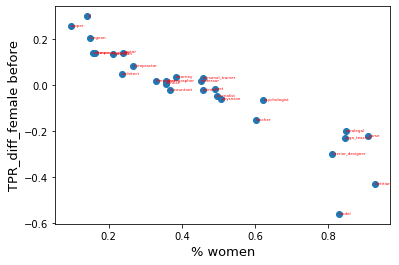

Correlation: -0.6852509098930057; p-value: 5.734344375527914e-05


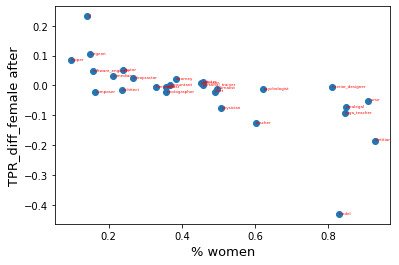

' \nfprs_before, fprs_change_before, mean_ratio_before = get_FPR(y_pred_before, Y_test, p2i, i2p, test_gender)\nsimilarity_vs_tpr(fprs_change_before, word2vec, "before", "FPR", prof2fem)\n\n\nfprs, fprs_change_after, mean_ratio_after = get_FPR(y_pred_after, Y_test, p2i, i2p, test_gender)\nsimilarity_vs_tpr(fprs_change_after, word2vec, "after", "FPR", prof2fem)\n\n#print("TPR diff ratio before: {}; after: {}".format(mean_ratio_before, mean_ratio_after))\n'

In [93]:
y_pred_before = clf_original.predict(X_test)
test_gender = [d["g"] for d in test]
tprs_before, tprs_change_before, mean_ratio_before = get_TPR(y_pred_before, Y_test, p2i, i2p, test_gender)
similarity_vs_tpr(tprs_change_before, word2vec, "before", "TPR", prof2fem)


y_pred_after = clf.predict(X_test.dot(P))
tprs, tprs_change_after, mean_ratio_after = get_TPR(y_pred_after, Y_test, p2i, i2p, test_gender)
similarity_vs_tpr(tprs_change_after, word2vec, "after", "TPR", prof2fem)

 
#print("TPR diff ratio before: {}; after: {}".format(mean_ratio_before, mean_ratio_after))
""" 
fprs_before, fprs_change_before, mean_ratio_before = get_FPR(y_pred_before, Y_test, p2i, i2p, test_gender)
similarity_vs_tpr(fprs_change_before, word2vec, "before", "FPR", prof2fem)


fprs, fprs_change_after, mean_ratio_after = get_FPR(y_pred_after, Y_test, p2i, i2p, test_gender)
similarity_vs_tpr(fprs_change_after, word2vec, "after", "FPR", prof2fem)

#print("TPR diff ratio before: {}; after: {}".format(mean_ratio_before, mean_ratio_after))
"""


In [22]:
test_gender

['f',
 'f',
 'm',
 'm',
 'm',
 'f',
 'f',
 'm',
 'm',
 'f',
 'm',
 'm',
 'f',
 'm',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'm',
 'f',
 'm',
 'f',
 'f',
 'm',
 'f',
 'f',
 'f',
 'm',
 'f',
 'm',
 'm',
 'f',
 'm',
 'f',
 'm',
 'm',
 'f',
 'm',
 'm',
 'f',
 'm',
 'f',
 'm',
 'm',
 'f',
 'f',
 'm',
 'm',
 'f',
 'm',
 'f',
 'm',
 'f',
 'm',
 'f',
 'f',
 'f',
 'f',
 'm',
 'm',
 'm',
 'm',
 'm',
 'f',
 'f',
 'f',
 'm',
 'f',
 'm',
 'f',
 'f',
 'f',
 'm',
 'm',
 'm',
 'f',
 'm',
 'm',
 'f',
 'm',
 'm',
 'f',
 'f',
 'm',
 'f',
 'f',
 'm',
 'm',
 'f',
 'f',
 'f',
 'm',
 'm',
 'm',
 'm',
 'm',
 'm',
 'f',
 'm',
 'f',
 'm',
 'f',
 'f',
 'f',
 'f',
 'm',
 'f',
 'f',
 'f',
 'm',
 'f',
 'm',
 'f',
 'f',
 'm',
 'm',
 'f',
 'm',
 'm',
 'f',
 'f',
 'f',
 'm',
 'f',
 'm',
 'f',
 'f',
 'm',
 'f',
 'f',
 'f',
 'm',
 'f',
 'f',
 'f',
 'm',
 'm',
 'm',
 'm',
 'm',
 'm',
 'm',
 'f',
 'f',
 'f',
 'm',
 'm',
 'f',
 'm',
 'f',
 'f',
 'f',
 'f',
 'm',
 'f',
 'm',
 'm',
 'f',
 'f',
 'f',
 'f',
 'f',
 'm',
 'm'

In [23]:
word2vec.most_similar("nurse", topn=30)

[('nurses', 0.8237278461456299),
 ('nurse-', 0.7592737674713135),
 ('doctor', 0.7461875677108765),
 ('nursing', 0.7382979393005371),
 ('non-nurse', 0.7323007583618164),
 ('Nurse', 0.732159435749054),
 ('nurse-practitioner', 0.7234420776367188),
 ('midwife', 0.7170587778091431),
 ('nurse.', 0.715023398399353),
 ('anesthetist', 0.690942108631134),
 ('physician', 0.683051347732544),
 ('nurse-midwife', 0.67833012342453),
 ('midwive', 0.6763737797737122),
 ('nurse.The', 0.6758171319961548),
 ('hospital', 0.6709805727005005),
 ('patient', 0.6638672351837158),
 ('nurse.She', 0.6578284502029419),
 ('ex-nurse', 0.6549866199493408),
 ('medic', 0.6527988314628601),
 ('laborist', 0.6470524072647095),
 ('pharmacist', 0.6424120664596558),
 ('Nurses', 0.6366264820098877),
 ('caregiver', 0.6364293694496155),
 ('paramedic', 0.6347559094429016),
 ('anaesthesiologist', 0.6335371732711792),
 ('nurse.I', 0.6332204937934875),
 ('nurs', 0.6315058469772339),
 ('surgeon', 0.630230724811554),
 ('nurses.', 0.628

In [78]:
test_count = count_profs_and_gender(test)

In [79]:
test_count

defaultdict(collections.Counter,
            {'professor': Counter({'f': 13350, 'm': 16055}),
             'physician': Counter({'f': 4897, 'm': 4628}),
             'attorney': Counter({'m': 5019, 'f': 3179}),
             'accountant': Counter({'f': 529, 'm': 943}),
             'photographer': Counter({'m': 3898, 'f': 2099}),
             'architect': Counter({'m': 1974, 'f': 613}),
             'painter': Counter({'m': 1070, 'f': 899}),
             'dentist': Counter({'f': 1296, 'm': 2338}),
             'model': Counter({'f': 1540, 'm': 336}),
             'surgeon': Counter({'f': 511, 'm': 2850}),
             'journalist': Counter({'f': 2418, 'm': 2582}),
             'nurse': Counter({'m': 433, 'f': 4295}),
             'composer': Counter({'f': 247, 'm': 1159}),
             'rapper': Counter({'m': 296, 'f': 39}),
             'psychologist': Counter({'f': 2733, 'm': 1766}),
             'teacher': Counter({'m': 1579, 'f': 2479}),
             'dj': Counter({'m': 315, 'f': 60